# An Example Using LineCleaner To Remove Some Lines From GW150914 Data

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
jax.config.update('jax_enable_x64', True)

import numpy as np

from jax import random
import jax.numpy as jnp

import numpyro
numpyro.set_host_device_count(10)

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import scipy.signal as sig

import h5py

import matplotlib.pyplot as plt

import arviz as az

from tqdm.notebook import tqdm

from line_cleaner import clean_strain

If you do not have the data file to hand, you can download it from GWOSC by un-commenting and executing the following cell.

In [3]:
# ! curl -O https://gwosc.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5

We will load the data, and set up some basic quantities:

In [ ]:
with h5py.File('H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5', 'r') as f:
    strain_data = jnp.array(f['strain/Strain'])
    GPSstart = f['meta']['GPSstart'][()]    
T = 4096 # seconds
srate = 4096 # Hz

# # Uncomment this line if you want to have raw GPS times; otherwise the time array 
# # is measured with respect to GPSstart
# strain_times = GPSstart + jnp.arange(len(strain_data))/srate
strain_times = jnp.arange(len(strain_data))/srate

Let's have a look at a PSD estimated from the data; we will tell `sig.welch` to use 16 second segments, and aggregate the spectrum estimated from each segement using `median`.

In [11]:
psd_seglen = 16
f, p = sig.welch(strain_data, fs=srate, nperseg=psd_seglen*srate, average='median')

What does it look like?

Text(0, 0.5, '$P(f) / \\mathrm{strain}^2 \\, \\mathrm{Hz}^{-1}$')

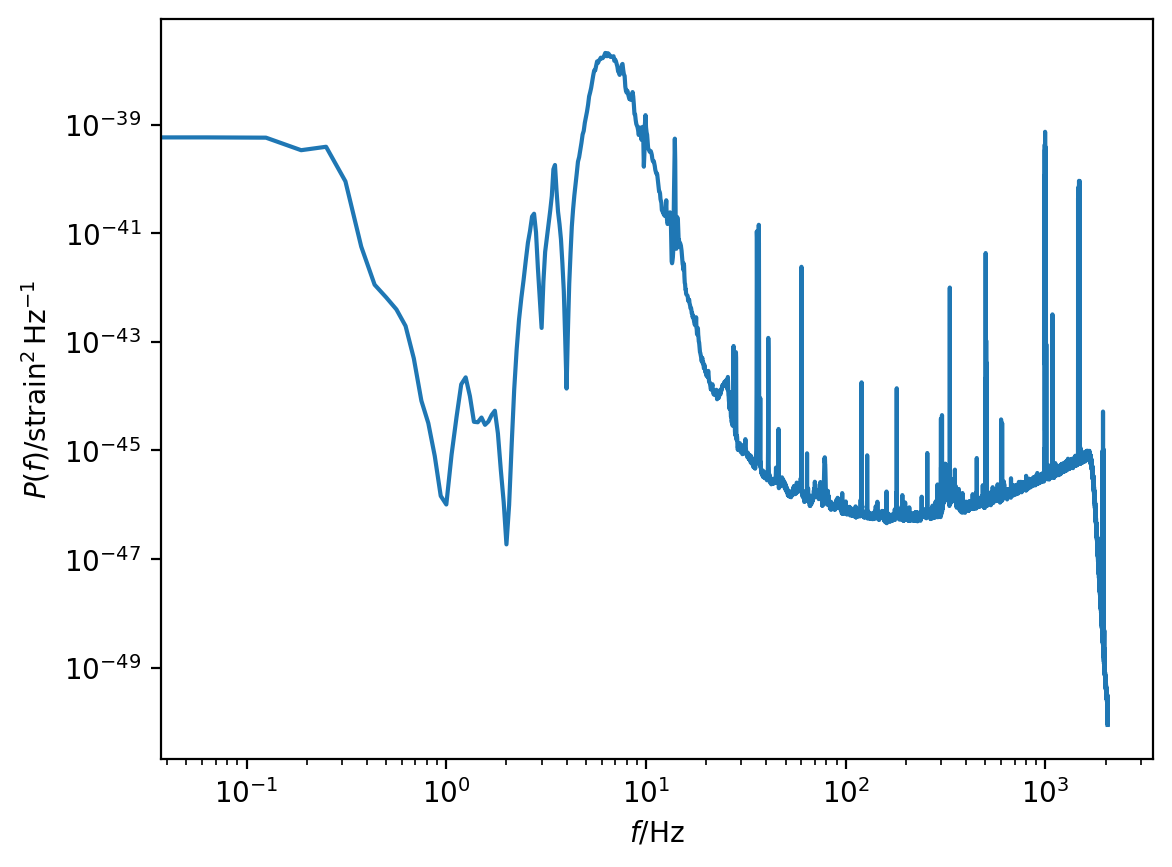

In [42]:
plt.loglog(f,p)
plt.xlabel(r'$f / \mathrm{Hz}$')
plt.ylabel(r'$P(f) / \mathrm{strain}^2 \, \mathrm{Hz}^{-1}$')

Let's zoom in, and see if there are some good lines that we can clean out; for each line, we will collect a narrow bandwidth range about which we can clean.

In [19]:
f0s = []
bws = []

First, 60 Hz:

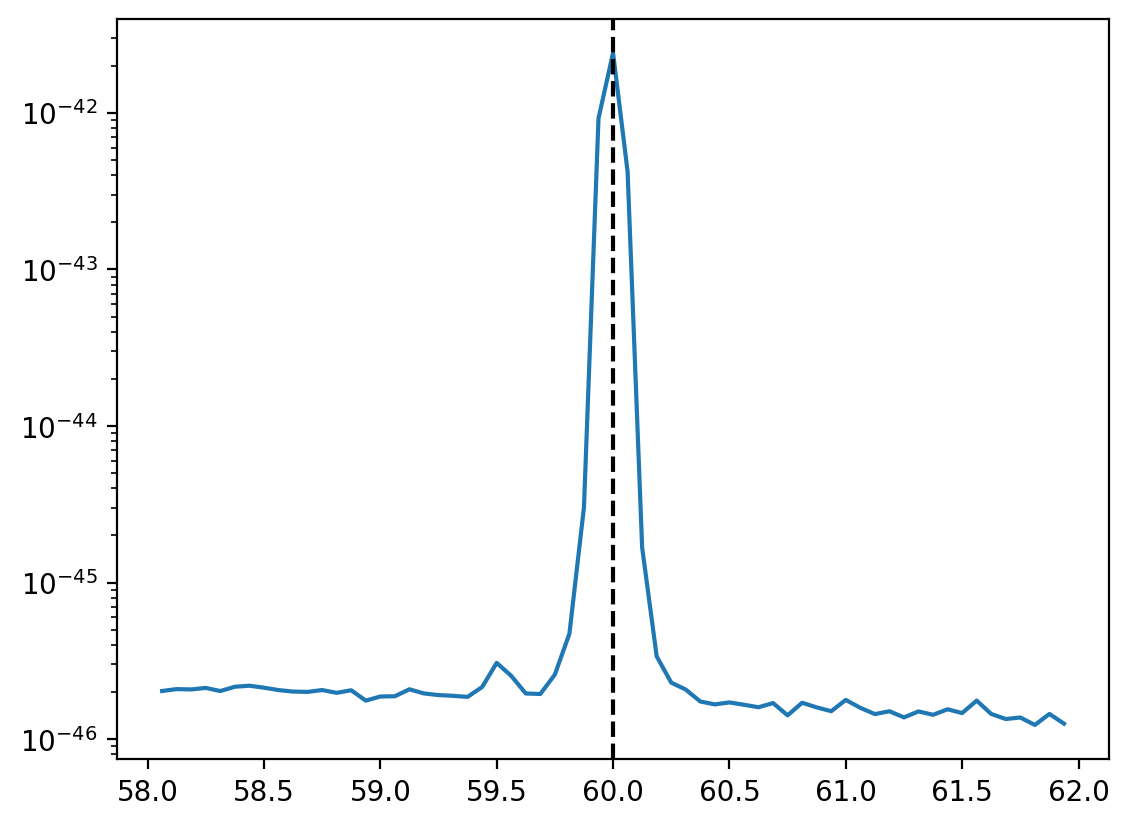

In [20]:
f0 = 60.0
bw = 4.0

sel = np.abs(f-f0) < bw/2
plt.plot(f[sel], p[sel])
plt.yscale('log')
plt.axvline(f0, ls='--', color='k')

f0s.append(f0)
bws.append(bw)

Now the strong line at 120 Hz:

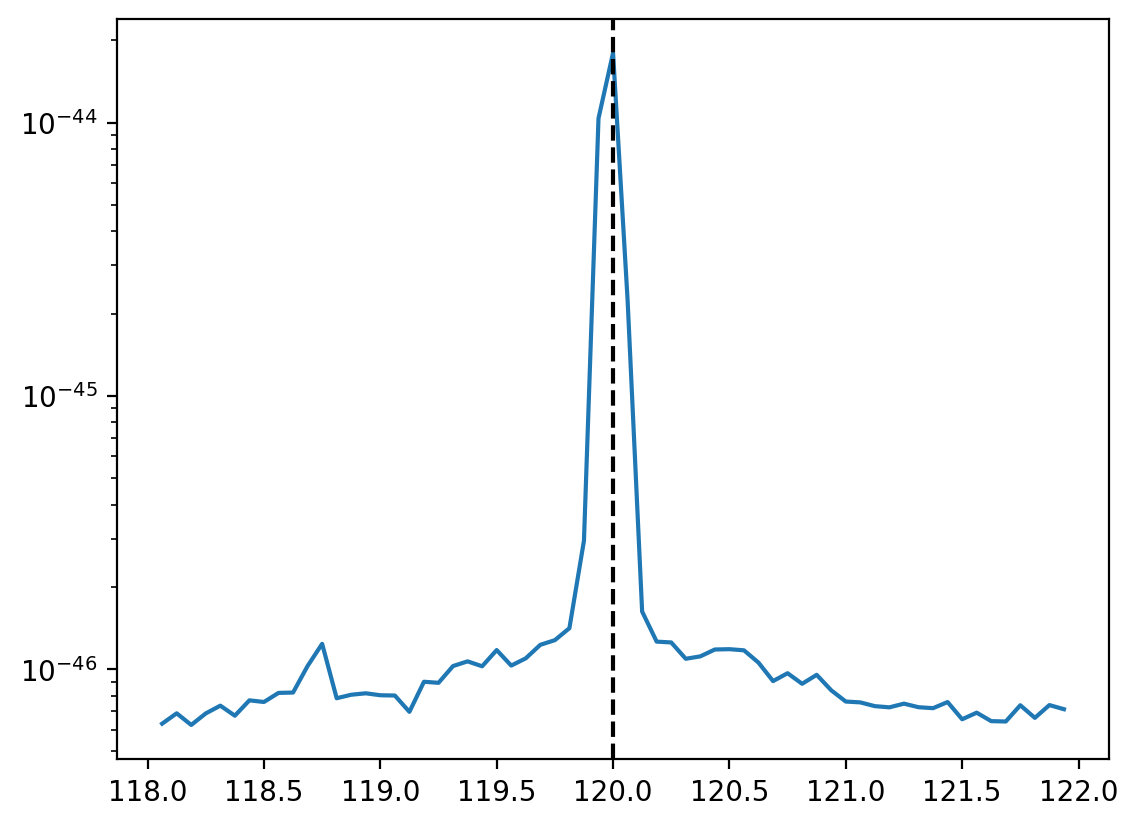

In [ ]:
f0 = 120.0
bw = 4.0

sel = np.abs(f-f0) < bw/2
plt.plot(f[sel], p[sel])
plt.yscale('log')
plt.axvline(f0, ls='--', color='k')

f0s.append(f0)
bws.append(bw)

And now at 180 Hz:

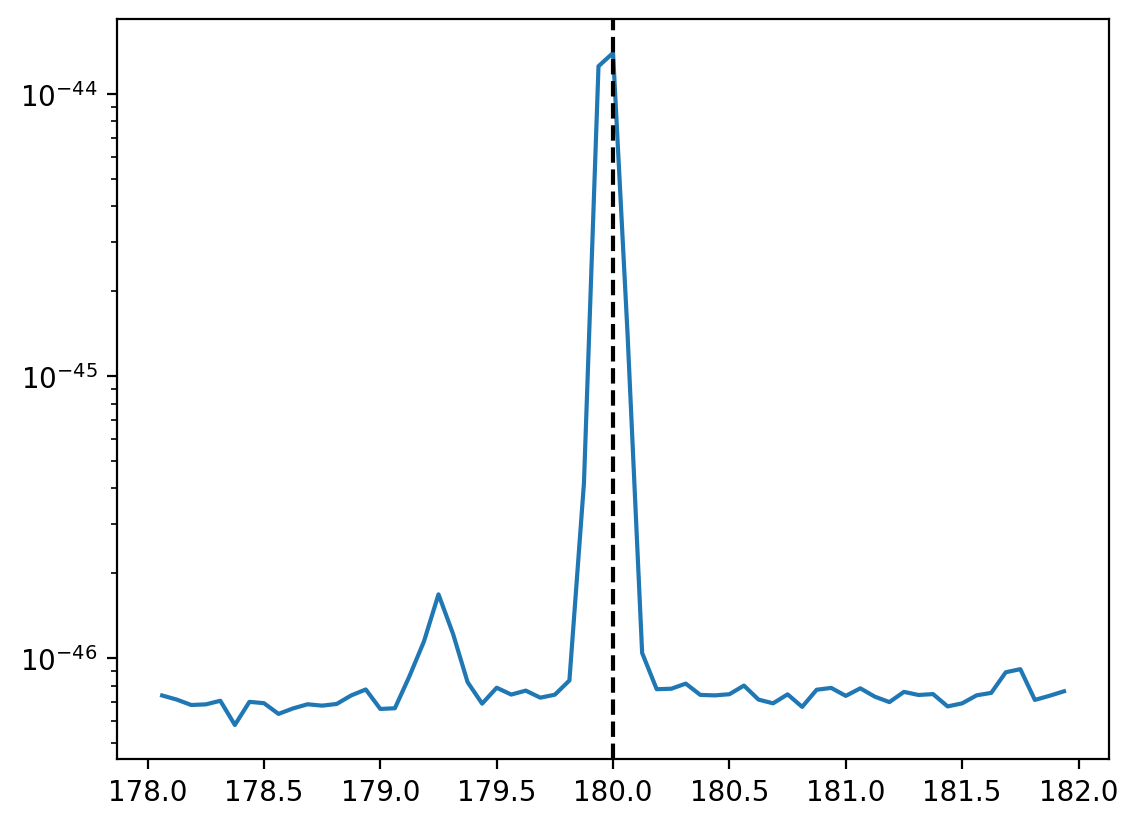

In [ ]:
f0 = 180.0
bw = 4.0

sel = np.abs(f-f0) < bw/2
plt.plot(f[sel], p[sel])
plt.yscale('log')
plt.axvline(f0, ls='--', color='k')

f0s.append(f0)
bws.append(bw)

In [43]:
print(f'I will be cleaning lines at {f0s} Hz, with bandwidths {bws} Hz')

I will be cleaning lines at [60.0, 120, 180] Hz, with bandwidths [4.0, 4.0, 4.0] Hz


Now let's clean the strain.  We give `clean_strain` the times, data, sample rate, and the list of frequencies and bandwidths to examine.  The final argument is the total amount of time (half at the beginning and half at the end of the segment) that we want to apply a window to before going into the Fourier domain.  This windowing procedure is necessary because the Fourier domain assumes periodicity of the signal, and we need to enforce that.  The cleaner will not report data within the windowed period (so the output segment will be 4096 - 16 = 4080 s long).

Because we are cleaning three narrow bands, the cleaner will run three MCMCs; each one will fit the Lorentzian plus constant continuum model to one of the bandwidths, draw a random sample of the line time series, and subtract to obtain line-cleaned data, passing these residuals on to the next MCMC.  (In principle these could be run in parallel, since the fits in the different bands are independent; but this complication hardly seems to be necessary).

If you want to make the sampling reproducable, you can pass an integer to `mcmc_seed`; if you *also* want to make the subtraction reproducable (i.e. to choose the same line-fit sample to generate residuals) you should pass an integer to `resample_seed`.

If you pass `return_mcmcs=True`, then in addition to the cleaned times and strain, the function will return a list of the MCMC objects and a list of the predicted line time series for each of the bands that were fit.

In [27]:
Twindow = 16.0
cleaned_times, cleaned_strain = clean_strain(strain_times, strain_data, srate, f0s, bws, Twindow)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Let's look at the PSD of the cleaned strain:

In [33]:
fc, pc = sig.welch(cleaned_strain, fs=srate, nperseg=psd_seglen*srate, average='median')

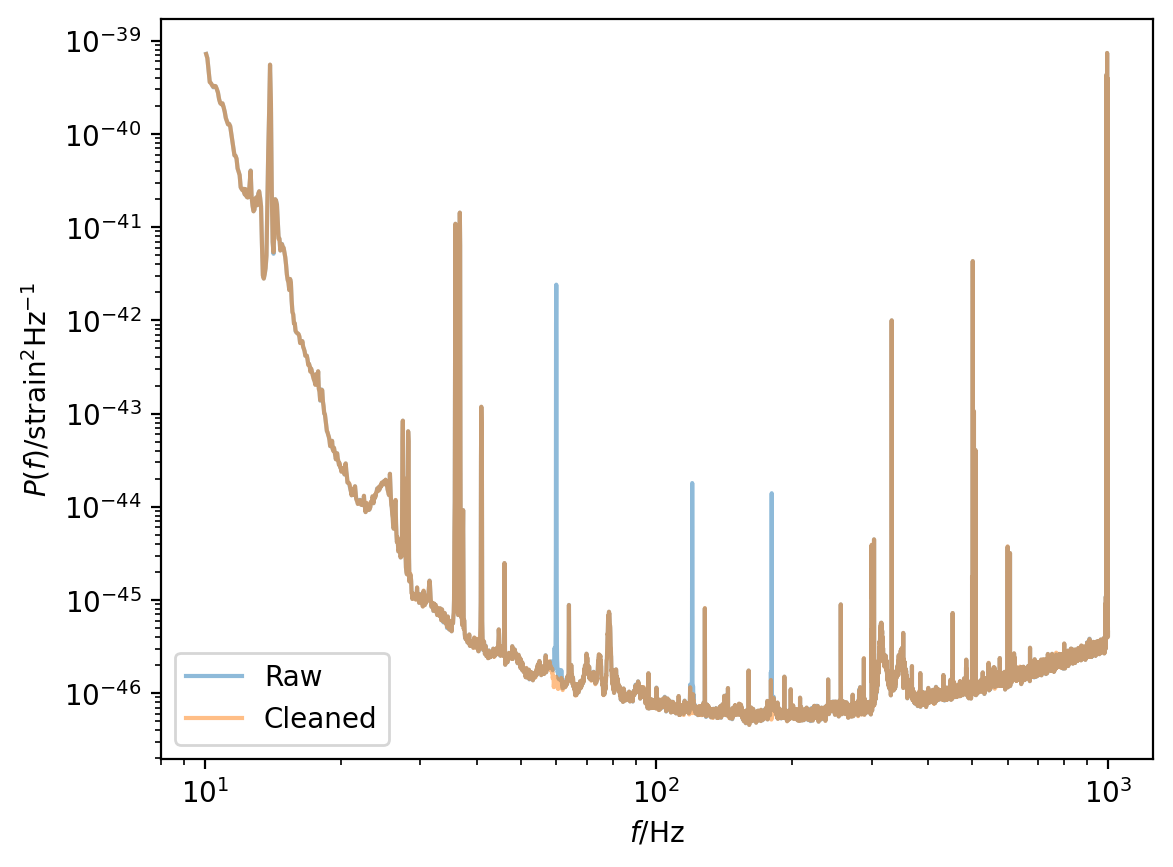

In [ ]:
sel = (f > 10) & (f < 1000)
plt.loglog(f[sel], p[sel], label="Raw", alpha=0.5)
plt.loglog(fc[sel], pc[sel], label="Cleaned", alpha=0.5)
plt.legend()
plt.xlabel(r'$f / \mathrm{Hz}$')
plt.ylabel(r'$P(f) / \mathrm{strain}^2 \mathrm{Hz}^{-1}$')

Let's zoom into each band in turn:

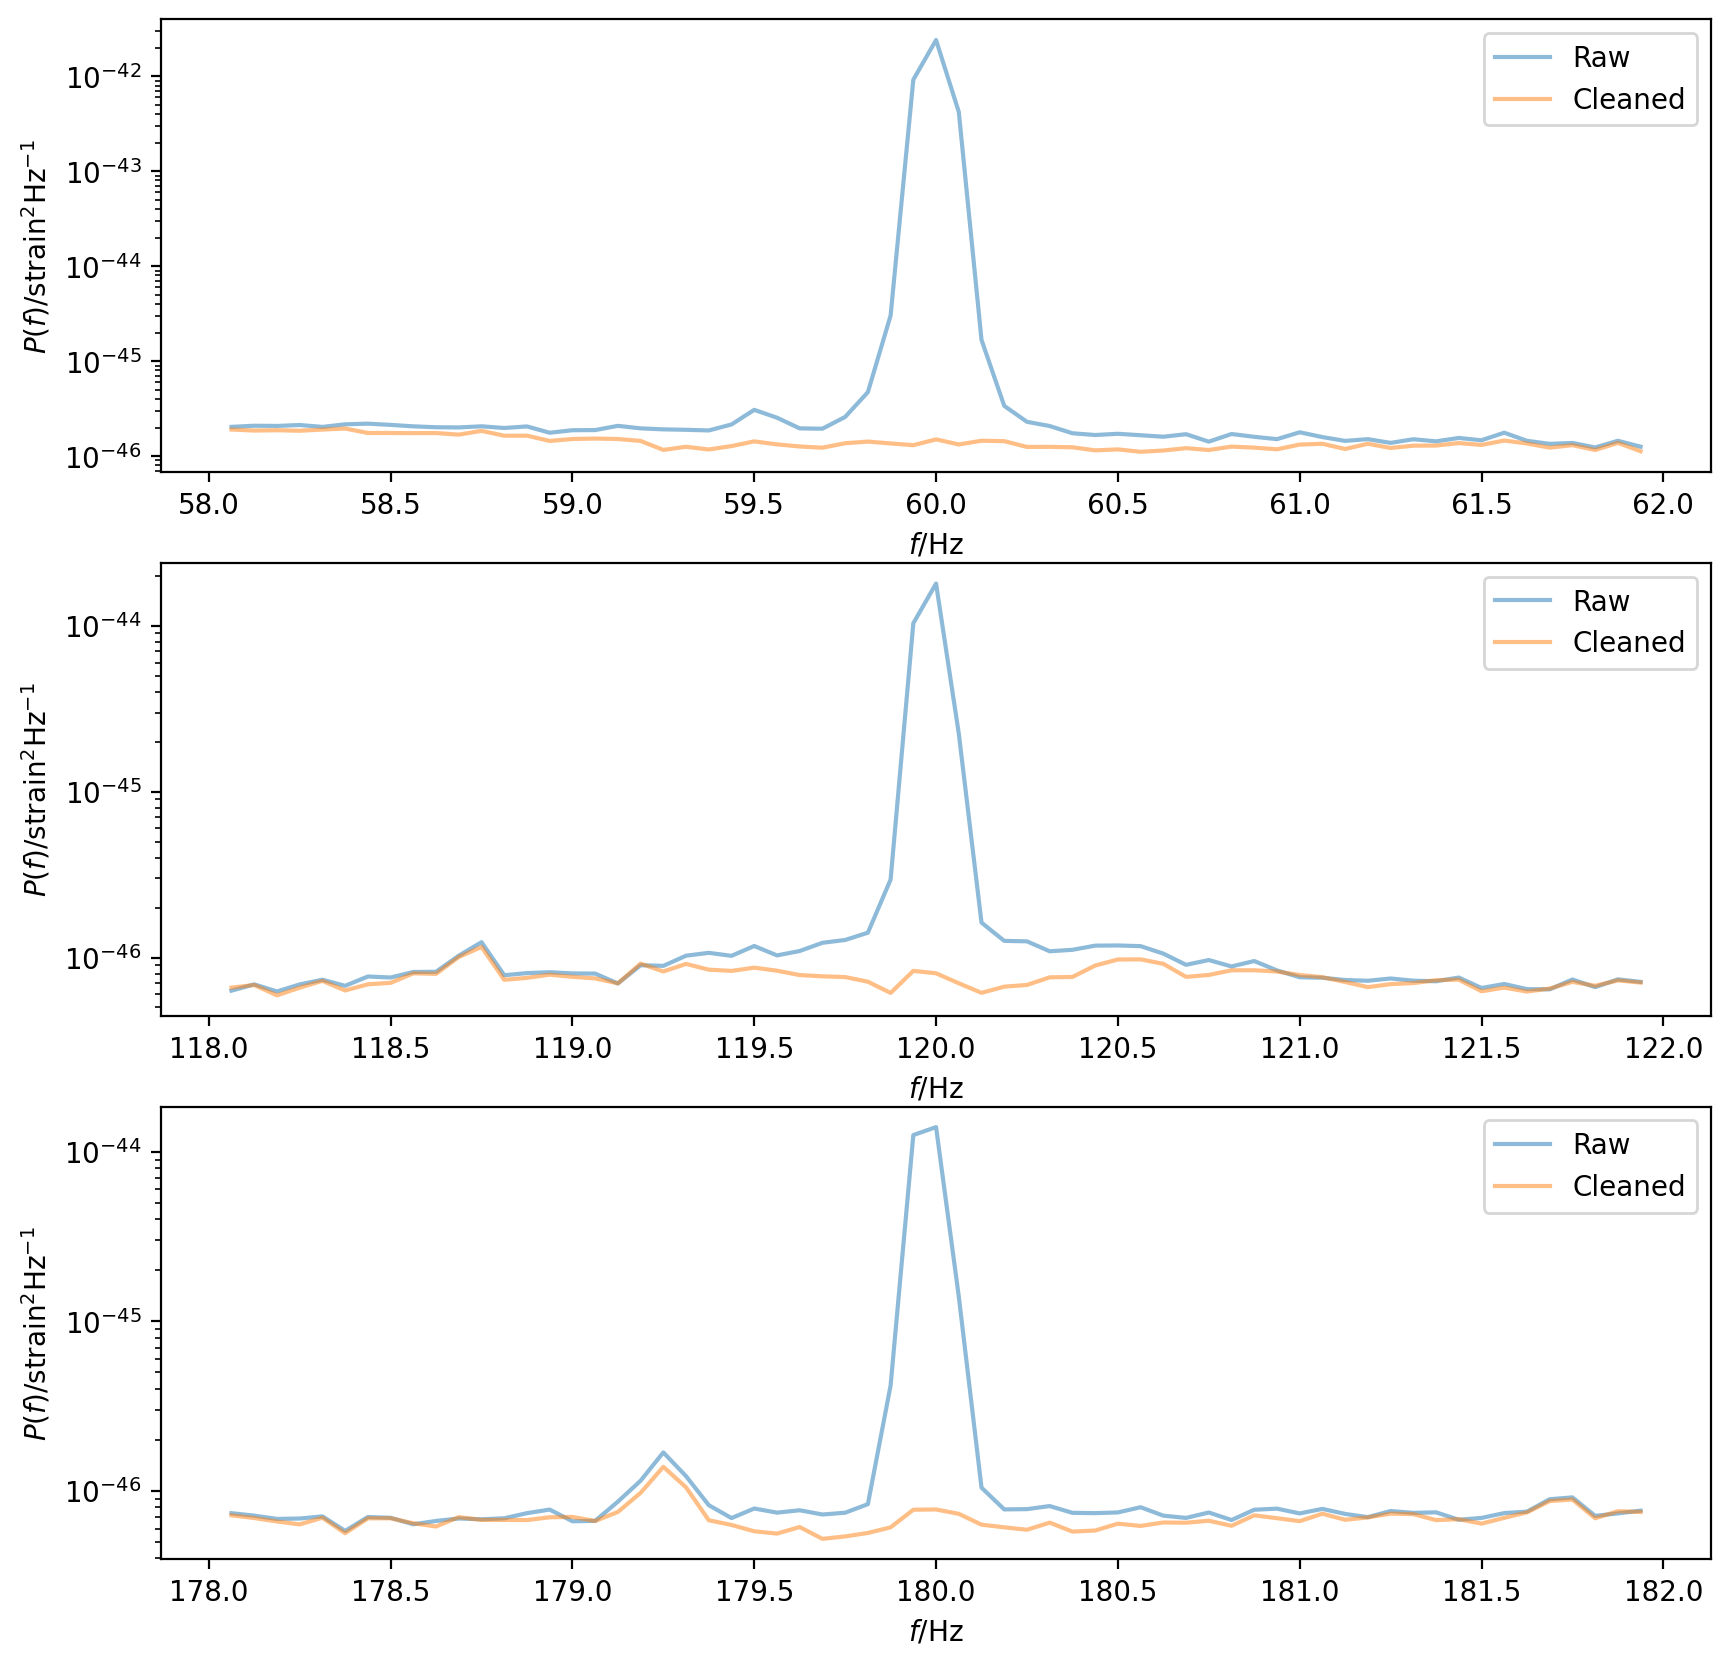

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for ax, f0, bw in zip(axs, f0s, bws):
    sel = np.abs(f - f0) < bw/2
    ax.plot(f[sel], p[sel], label=f'Raw', alpha=0.5)
    ax.plot(fc[sel], pc[sel], label=f'Cleaned', alpha=0.5)
    ax.set_yscale('log')
    ax.set_xlabel(r'$f / \mathrm{Hz}$')
    ax.set_ylabel(r'$P(f) / \mathrm{strain}^2 \mathrm{Hz}^{-1}$')
    ax.legend()

If we wanted to, we could now save the cleaned strain, or further process it....